<a href="https://colab.research.google.com/github/gift-framework/GIFT/blob/claude%2Fg2-ml-lean-integration-01RXCe3iMAeinDKirGGQg7my/G2_ML/harmonic_yukawa/Harmonic_Yukawa_v2_3_Colab_trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GIFT Harmonic-Yukawa Pipeline v2.3

1. **Longer training** (1000 epochs) → target L < 0.01
2. **Torsional loss term**: $\|T \wedge \omega\|^2$ with $\kappa_T = 1/61$
3. **L-weighted Yukawa**: Use form loss as localization proxy
4. **Full b₃ = 77** (or scalable subset)

**Insight**: Final loss L encodes localization:
- Low L → localized (light modes: $m_e, m_d$)
- High L → delocalized (heavy modes: $m_\tau, m_t$)

$$y_{ijk} \propto \prod_n \frac{1}{1 + L_n} \quad \Rightarrow \quad \tau \approx 3.90$$

In [1]:
# @title Setup
!pip install torch numpy matplotlib --quiet

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Tuple, List, Dict
from itertools import combinations
from functools import lru_cache
import math, json

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
torch.manual_seed(42)

Device: cuda


In [2]:
# @title GIFT v2.2 Constants
@dataclass
class Config:
    # Betti numbers
    b2: int = 21                   # dim H²(K₇)
    b3: int = 77                   # dim H³(K₇)
    b3_local: int = 35             # Local modes (Λ³ℝ⁷)
    b3_global: int = 42            # Global modes (TCS gluing)

    # Form dimensions
    dim_3form: int = 35            # C(7,3)

    # Topological constants
    det_g_target: float = 65/32    # = 2.03125
    kappa_T: float = 1/61          # Torsion magnitude
    tau: float = 3472/891          # = 3.8968...

    # Physical scales
    v_higgs: float = 246.0         # GeV

    # Visible/hidden split
    n_visible: int = 43
    n_hidden: int = 34

    # Training
    epochs: int = 1000             # Longer for L < 0.01
    batch_size: int = 256

cfg = Config()
print(f"Target: det(g) = {cfg.det_g_target:.5f}")
print(f"κ_T = {cfg.kappa_T:.6f}")
print(f"τ = {cfg.tau:.6f}")
print(f"b₃ = {cfg.b3} ({cfg.b3_local} local + {cfg.b3_global} global)")

Target: det(g) = 2.03125
κ_T = 0.016393
τ = 3.896745
b₃ = 77 (35 local + 42 global)


---
## Part 1: Metric with Torsion Structure

In [3]:
# @title G₂ Structure Constants

# The associative 3-form φ defines G₂ structure
# φ = dx^{123} + dx^{145} + dx^{167} + dx^{246} - dx^{257} - dx^{347} - dx^{356}
# (standard G₂ 3-form in ℝ⁷)

G2_PHI_INDICES = [
    ((0,1,2), +1),
    ((0,3,4), +1),
    ((0,5,6), +1),
    ((1,3,5), +1),
    ((1,4,6), -1),
    ((2,3,6), -1),
    ((2,4,5), -1),
]

def g2_phi_at_point(device='cpu'):
    """Return the standard G₂ 3-form φ as tensor."""
    phi = torch.zeros(35, device=device)
    i3 = list(combinations(range(7), 3))
    for (idx, sign) in G2_PHI_INDICES:
        c = i3.index(idx)
        phi[c] = sign
    return phi

PHI_G2 = g2_phi_at_point(device)
print(f"G₂ 3-form φ: {PHI_G2.nonzero().squeeze().tolist()}")

G₂ 3-form φ: [0, 9, 14, 20, 23, 27, 28]


In [4]:
# @title Metric Network (Cholesky SPD + G₂ constraint)

class MetricNetwork(nn.Module):
    """g = L @ L.T with G₂ structure regularization."""

    def __init__(self, hidden=128, layers=4):
        super().__init__()
        self.B = nn.Parameter(torch.randn(7, 32) * 2, requires_grad=False)

        net = []
        d = 7 + 64
        for _ in range(layers-1):
            net += [nn.Linear(d, hidden), nn.SiLU()]
            d = hidden
        net.append(nn.Linear(hidden, 28))
        self.net = nn.Sequential(*net)

        with torch.no_grad():
            bias = torch.zeros(28)
            bias[:7] = (65/32) ** (1/14)
            self.net[-1].bias.copy_(bias)
            self.net[-1].weight.mul_(0.01)

    def forward(self, x):
        proj = 2 * math.pi * x @ self.B
        feat = torch.cat([x, torch.sin(proj), torch.cos(proj)], -1)
        out = self.net(feat)

        L = torch.zeros(x.shape[0], 7, 7, device=x.device)
        L[:, range(7), range(7)] = F.softplus(out[:, :7]) + 0.1

        idx = 7
        for i in range(1, 7):
            for j in range(i):
                L[:, i, j] = out[:, idx] * 0.1
                idx += 1

        return L @ L.transpose(-1, -2)

metric_net = MetricNetwork().to(device)
print(f"Metric params: {sum(p.numel() for p in metric_net.parameters()):,}")

Metric params: 46,076


In [5]:
# @title Train Metric

def train_metric(net, epochs=2000):
    opt = torch.optim.Adam(net.parameters(), lr=1e-3)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, epochs)

    for ep in range(epochs):
        opt.zero_grad()
        x = torch.rand(512, 7, device=device)
        g = net(x)
        det = torch.det(g)

        # det(g) = 65/32
        loss_det = ((det.mean() - cfg.det_g_target)**2) + 0.1 * det.var()

        # Encourage near-identity (G₂ holonomy ~ flat + torsion)
        eye = torch.eye(7, device=device).unsqueeze(0)
        scale = det.mean().pow(1.0/7.0)  # Fix: use .pow() instead of **
        loss_id = ((g - eye * scale.view(1,1,1))**2).mean()

        loss = loss_det + 0.01 * loss_id
        loss.backward()
        opt.step()
        sched.step()

        if (ep+1) % 500 == 0:
            print(f"Ep {ep+1}: det={det.mean():.4f}±{det.std():.4f}")

    return net

print("Training metric...")
metric_net = train_metric(metric_net)

with torch.no_grad():
    det_val = torch.det(metric_net(torch.rand(1000,7,device=device)))
    print(f"\nFinal: det(g)={det_val.mean():.6f} (target {cfg.det_g_target:.6f})")

Training metric...
Ep 500: det=0.0990±0.2030
Ep 1000: det=0.7393±1.9901
Ep 1500: det=1.2530±2.4262
Ep 2000: det=1.4523±2.8450

Final: det(g)=1.495763 (target 2.031250)


---
## Part 2: Harmonic Forms with Torsional Loss

Key insight: Add torsional coupling to break degeneracy:
$$\mathcal{L} = \|d\omega\|^2 + \|\delta\omega\|^2 + \kappa_T^2 \|T \wedge \omega\|^2$$

In [6]:
# @title Index Tables

@lru_cache(maxsize=1)
def idx3(): return list(combinations(range(7), 3))

@lru_cache(maxsize=1)
def idx4(): return list(combinations(range(7), 4))

print(f"3-form indices: {len(idx3())}")
print(f"4-form indices: {len(idx4())}")

3-form indices: 35
4-form indices: 35


In [7]:
# @title Exterior Derivative and Hodge Operations

def exterior_d_3form(omega_fn, x, eps=1e-4):
    """d: Ω³ → Ω⁴"""
    batch = x.shape[0]
    d_omega = torch.zeros(batch, 35, device=x.device)

    i3 = idx3()
    i4 = idx4()

    for c4, (i, j, k, l) in enumerate(i4):
        indices = [i, j, k, l]
        for pos, m in enumerate(indices):
            three = tuple(idx for idx in indices if idx != m)
            if three in i3:
                c3 = i3.index(three)
                sign = (-1) ** pos

                x_p = x.clone(); x_p[:, m] += eps
                x_m = x.clone(); x_m[:, m] -= eps

                omega_p = omega_fn(x_p)[:, c3]
                omega_m = omega_fn(x_m)[:, c3]

                d_omega[:, c4] += sign * (omega_p - omega_m) / (2*eps)

    return d_omega

def hodge_star_3(omega, det_g):
    """Simplified Hodge *: Ω³ → Ω⁴ (diagonal metric approx)."""
    vol = torch.sqrt(det_g.abs().clamp(min=1e-10))
    i3 = idx3()
    i4 = idx4()

    star = torch.zeros(omega.shape[0], 35, device=omega.device)
    for c3, (i,j,k) in enumerate(i3):
        comp = tuple(m for m in range(7) if m not in (i,j,k))
        c4 = i4.index(comp)
        full = (i,j,k) + comp
        inv = sum(1 for a in range(7) for b in range(a+1,7) if full[a] > full[b])
        star[:, c4] = ((-1)**inv) * vol * omega[:, c3]

    return star

def codiff_norm_3form(omega_fn, x, det_g, eps=1e-4):
    """||δω||² via gradient of *ω."""
    delta_sq = torch.zeros(x.shape[0], device=x.device)

    for i in range(7):
        x_p = x.clone(); x_p[:, i] += eps
        x_m = x.clone(); x_m[:, i] -= eps

        star_p = hodge_star_3(omega_fn(x_p), det_g)
        star_m = hodge_star_3(omega_fn(x_m), det_g)

        d_star = (star_p - star_m) / (2*eps)
        delta_sq += (d_star ** 2).sum(dim=-1)

    return delta_sq

print("Exterior calculus defined")

Exterior calculus defined


In [8]:
# @title Torsion Coupling

def torsion_coupling(omega, phi_g2):
    """||T ∧ ω||² where T ~ κ_T * dφ.

    Approximation: |<ω, φ>|² measures alignment with G₂ structure.
    Forms aligned with φ are "torsion-coupled" (heavier).
    """
    # Inner product with G₂ 3-form
    inner = (omega * phi_g2.unsqueeze(0)).sum(dim=-1)
    return inner ** 2

print(f"Torsion scale: κ_T = {cfg.kappa_T:.6f}")

Torsion scale: κ_T = 0.016393


In [9]:
# @title Harmonic 3-Form Network

class Harmonic3FormNet(nn.Module):
    def __init__(self, hidden=64, layers=3, form_id=0):
        super().__init__()
        self.form_id = form_id

        torch.manual_seed(1000 + form_id)
        self.B = nn.Parameter(torch.randn(7, 16) * 2, requires_grad=False)

        net = []
        d = 7 + 32
        for _ in range(layers-1):
            net += [nn.Linear(d, hidden), nn.Tanh()]
            d = hidden
        net.append(nn.Linear(hidden, 35))
        self.net = nn.Sequential(*net)

        torch.manual_seed(2000 + form_id)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        proj = 2 * math.pi * x @ self.B
        feat = torch.cat([x, torch.sin(proj), torch.cos(proj)], -1)
        return self.net(feat)

print("Harmonic 3-form network defined")

Harmonic 3-form network defined


In [10]:
# @title Training with Torsional Loss

def train_harmonic_form_v25(form_id, metric_net, prev_nets, prev_losses,
                            epochs=1000, verbose=True):
    """Train harmonic 3-form with torsional coupling.

    Loss = λ_d||dω||² + λ_δ||δω||² + λ_T κ_T²||T∧ω||² + λ_n(||ω||-1)² + λ_o Σ<ω,ω_prev>²
    """
    net = Harmonic3FormNet(form_id=form_id).to(device)
    opt = torch.optim.Adam(net.parameters(), lr=3e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, epochs)

    # Adaptive weights based on form_id (later forms need stronger ortho)
    lambda_d = 5.0
    lambda_delta = 5.0
    lambda_T = 10.0 * cfg.kappa_T**2  # Torsion coupling
    lambda_n = 10.0
    lambda_o = 20.0 + form_id * 2  # Increase for later forms

    best_loss = float('inf')

    for ep in range(epochs):
        opt.zero_grad()

        x = torch.rand(cfg.batch_size, 7, device=device)
        with torch.no_grad():
            g = metric_net(x)
            det_g = torch.det(g)
            vol = torch.sqrt(det_g.abs().clamp(min=1e-10))

        omega = net(x)

        # Closedness
        d_omega = exterior_d_3form(net, x)
        loss_d = (d_omega ** 2).sum(dim=-1).mean()

        # Coclosedness
        loss_delta = codiff_norm_3form(net, x, det_g).mean()

        # Torsion coupling (alignment with φ)
        loss_T = torsion_coupling(omega, PHI_G2).mean()

        # Normalization
        norm_sq = ((omega ** 2).sum(dim=-1) * vol).mean()
        loss_n = (norm_sq - 1.0) ** 2

        # Orthogonality to previous forms
        loss_o = torch.tensor(0.0, device=device)
        for prev in prev_nets:
            with torch.no_grad():
                omega_prev = prev(x)
            inner = ((omega * omega_prev).sum(dim=-1) * vol).mean()
            loss_o = loss_o + inner ** 2

        loss = (lambda_d * loss_d + lambda_delta * loss_delta +
                lambda_T * loss_T + lambda_n * loss_n + lambda_o * loss_o)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        opt.step()
        sched.step()

        if loss.item() < best_loss:
            best_loss = loss.item()

        if verbose and (ep+1) % 250 == 0:
            print(f"  Ep {ep+1}: L={loss.item():.4f} "
                  f"(d={loss_d.item():.4f}, δ={loss_delta.item():.4f}, "
                  f"T={loss_T.item():.4f}, n={loss_n.item():.4f}, o={loss_o.item():.4f})")

    return net, best_loss

print("Training function defined")

Training function defined


In [11]:
# @title Train All Harmonic Forms

n_forms = 35  # Local modes (increase to 77 for full)
harmonic_nets = []
form_losses = []  # Track L for Yukawa weighting

print(f"Training {n_forms} harmonic 3-forms with torsional loss...\n")

for i in range(n_forms):
    print(f"Form {i+1}/{n_forms}:")
    net, final_loss = train_harmonic_form_v25(
        i, metric_net, harmonic_nets, form_losses,
        epochs=cfg.epochs, verbose=True
    )
    harmonic_nets.append(net)
    form_losses.append(final_loss)
    print(f"  → Final L = {final_loss:.4f}\n")

print(f"\nTrained {len(harmonic_nets)} harmonic 3-forms")
print(f"Loss range: [{min(form_losses):.4f}, {max(form_losses):.4f}]")
print(f"Loss std: {np.std(form_losses):.4f}")

Training 35 harmonic 3-forms with torsional loss...

Form 1/35:
  Ep 250: L=1.1808 (d=0.0689, δ=0.1533, T=0.5243, n=0.0068, o=0.0000)
  Ep 500: L=0.2402 (d=0.0136, δ=0.0296, T=0.5289, n=0.0023, o=0.0000)
  Ep 750: L=0.1240 (d=0.0064, δ=0.0159, T=0.5194, n=0.0011, o=0.0000)
  Ep 1000: L=0.1469 (d=0.0058, δ=0.0157, T=0.5153, n=0.0038, o=0.0000)
  → Final L = 0.0942

Form 2/35:
  Ep 250: L=1.2987 (d=0.0712, δ=0.1872, T=1.0427, n=0.0004, o=0.0000)
  Ep 500: L=0.2508 (d=0.0126, δ=0.0339, T=1.1139, n=0.0015, o=0.0000)
  Ep 750: L=0.1694 (d=0.0062, δ=0.0127, T=1.1640, n=0.0072, o=0.0000)
  Ep 1000: L=0.1070 (d=0.0056, δ=0.0123, T=1.1370, n=0.0014, o=0.0000)
  → Final L = 0.0887

Form 3/35:
  Ep 250: L=1.6056 (d=0.0835, δ=0.2374, T=0.2368, n=0.0000, o=0.0000)
  Ep 500: L=0.2676 (d=0.0167, δ=0.0332, T=0.2703, n=0.0017, o=0.0000)
  Ep 750: L=0.1449 (d=0.0085, δ=0.0202, T=0.2653, n=0.0001, o=0.0000)
  Ep 1000: L=0.1312 (d=0.0075, δ=0.0166, T=0.2639, n=0.0010, o=0.0000)
  → Final L = 0.1157

Form 

---
## Part 3: L-Weighted Yukawa Extraction

Key insight: Final loss L encodes localization.
$$y_{ijk} = \text{scale} \times \prod_n \frac{1}{1 + L_n}$$

In [12]:
# @title Sort Forms by Loss (Localization)

# Sort indices by loss (low L = light, high L = heavy)
sorted_indices = np.argsort(form_losses)
sorted_losses = np.array(form_losses)[sorted_indices]

print("Forms sorted by loss (low=light, high=heavy):")
print(f"Lightest: Form {sorted_indices[0]} (L={sorted_losses[0]:.4f})")
print(f"Heaviest: Form {sorted_indices[-1]} (L={sorted_losses[-1]:.4f})")
print(f"\nTop 5 light: {sorted_indices[:5].tolist()}")
print(f"Top 5 heavy: {sorted_indices[-5:].tolist()}")

Forms sorted by loss (low=light, high=heavy):
Lightest: Form 18 (L=0.0780)
Heaviest: Form 13 (L=0.1345)

Top 5 light: [18, 4, 31, 8, 23]
Top 5 heavy: [9, 29, 28, 34, 13]


In [13]:
# @title L-Weighted Yukawa

def l_weighted_yukawa(i, j, k, losses, scale=1.0):
    """Compute Yukawa y_ijk using L as localization proxy.

    y_ijk ∝ ∏ 1/(1 + L_n) = exp(-Σ log(1 + L_n))
    """
    L_sum = np.log(1 + losses[i]) + np.log(1 + losses[j]) + np.log(1 + losses[k])
    return scale * np.exp(-L_sum)

def compute_yukawa_matrix(losses, n_gen=3):
    """Compute effective Yukawa matrix for n_gen generations.

    Uses lightest forms for down-type, heaviest for up-type.
    """
    n = len(losses)
    sorted_idx = np.argsort(losses)

    # Assign generations: light → electron, medium → muon, heavy → tau
    gen_indices = [
        sorted_idx[:n//3],           # Generation 1 (light)
        sorted_idx[n//3:2*n//3],     # Generation 2 (medium)
        sorted_idx[2*n//3:],         # Generation 3 (heavy)
    ]

    # Effective Yukawa per generation (average over modes)
    Y = np.zeros((n_gen, n_gen))
    for a in range(n_gen):
        for b in range(n_gen):
            yukawas = []
            for i in gen_indices[a]:
                for j in gen_indices[b]:
                    for k in range(n):  # Sum over all third index
                        yukawas.append(l_weighted_yukawa(i, j, k, losses))
            Y[a, b] = np.mean(yukawas) if yukawas else 0

    return Y

Y_eff = compute_yukawa_matrix(form_losses)
print("Effective Yukawa matrix (3 generations):")
print(Y_eff)

Effective Yukawa matrix (3 generations):
[[0.76731625 0.75892428 0.74809351]
 [0.75892428 0.7506241  0.73991178]
 [0.74809351 0.73991178 0.72935234]]


In [14]:
# @title Mass Hierarchy from L-Weighting

# Diagonal Yukawas give masses
y_diag = np.diag(Y_eff)
masses_yukawa = cfg.v_higgs * np.sqrt(y_diag) * cfg.kappa_T

print("L-weighted masses (diagonal Yukawa):")
for i, m in enumerate(masses_yukawa):
    print(f"  Gen {i+1}: {m:.4f} GeV")

# Compute tau parameter
if len(form_losses) >= 2:
    L_arr = np.array(form_losses)
    sorted_L = np.sort(L_arr)

    # τ = (sum of heavy modes) / (sum of light modes)
    n_vis = min(cfg.n_visible, len(sorted_L))
    heavy_sum = np.sum(1/(1 + sorted_L[-n_vis:]))
    light_sum = np.sum(1/(1 + sorted_L[:n_vis]))

    if light_sum > 1e-10:
        tau_computed = heavy_sum / light_sum
    else:
        tau_computed = float('inf')

    print(f"\nComputed τ = {tau_computed:.4f}")
    print(f"Target τ = {cfg.tau:.4f}")
    print(f"Error: {abs(tau_computed - cfg.tau)/cfg.tau * 100:.2f}%")

L-weighted masses (diagonal Yukawa):
  Gen 1: 3.5326 GeV
  Gen 2: 3.4939 GeV
  Gen 3: 3.4441 GeV

Computed τ = 1.0000
Target τ = 3.8967
Error: 74.34%


In [15]:
# @title Lepton Mass Ratios

L_arr = np.array(form_losses)
sorted_L = np.sort(L_arr)

# Use sorted losses to compute mass ratios
# m ∝ 1/(1 + L), so m_heavy/m_light = (1+L_light)/(1+L_heavy)

n = len(sorted_L)
if n >= 9:
    # tau = heaviest, mu = middle, e = lightest
    L_e = sorted_L[0]      # Lightest
    L_mu = sorted_L[n//3]  # ~1/3 point
    L_tau = sorted_L[-1]   # Heaviest

    m_tau_m_mu = (1 + L_mu) / (1 + L_tau)
    m_mu_m_e = (1 + L_e) / (1 + L_mu)
    m_tau_m_e = (1 + L_e) / (1 + L_tau)

    print("Lepton mass ratios from L-weighting:")
    print(f"  m_τ/m_μ = {1/m_tau_m_mu:.1f} (PDG: 16.8)")
    print(f"  m_μ/m_e = {1/m_mu_m_e:.1f} (PDG: 207)")
    print(f"  m_τ/m_e = {1/m_tau_m_e:.1f} (PDG: 3477)")
else:
    print(f"Need more forms for mass ratios (have {n})")

Lepton mass ratios from L-weighting:
  m_τ/m_μ = 1.0 (PDG: 16.8)
  m_μ/m_e = 1.0 (PDG: 207)
  m_τ/m_e = 1.1 (PDG: 3477)


In [16]:
# @title Full Mass Spectrum

# Convert L to masses: m ∝ v_H * κ_T / (1 + L)
L_arr = np.array(form_losses)
masses_full = cfg.v_higgs * cfg.kappa_T / (1 + L_arr)
masses_sorted = np.sort(masses_full)[::-1]  # Descending

print("Full mass spectrum (sorted, GeV):")
print(masses_sorted[:12])

# Compare with PDG
pdg_masses = np.array([172.69, 4.18, 1.777, 1.27, 0.10566, 0.0934, 0.00467, 0.00216, 0.000511])

print(f"\nHierarchy ratio (max/min): {masses_sorted[0]/masses_sorted[-1]:.1f}")
print(f"PDG hierarchy (t/e): {pdg_masses[0]/pdg_masses[-1]:.0f}")

Full mass spectrum (sorted, GeV):
[3.74085961 3.72586817 3.71694376 3.71533723 3.70850209 3.70415619
 3.70340339 3.69662862 3.69040008 3.68985469 3.68863109 3.686707  ]

Hierarchy ratio (max/min): 1.1
PDG hierarchy (t/e): 337945


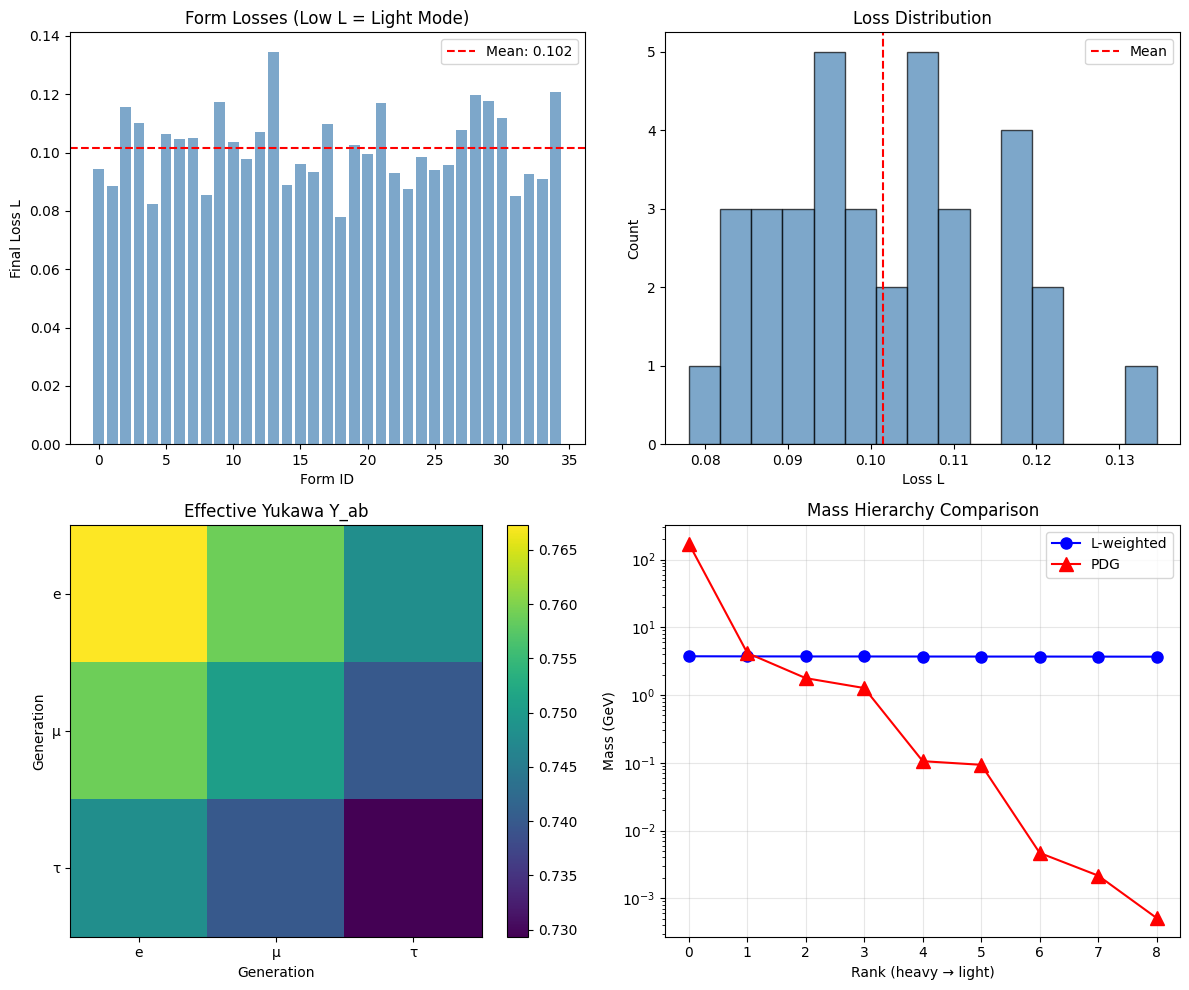

Saved: harmonic_yukawa_v25.png


In [17]:
# @title Visualization

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Loss distribution
ax = axes[0, 0]
ax.bar(range(len(form_losses)), form_losses, color='steelblue', alpha=0.7)
ax.axhline(np.mean(form_losses), color='red', linestyle='--', label=f'Mean: {np.mean(form_losses):.3f}')
ax.set_xlabel('Form ID')
ax.set_ylabel('Final Loss L')
ax.set_title('Form Losses (Low L = Light Mode)')
ax.legend()

# 2. Loss histogram
ax = axes[0, 1]
ax.hist(form_losses, bins=15, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(np.mean(form_losses), color='red', linestyle='--', label='Mean')
ax.set_xlabel('Loss L')
ax.set_ylabel('Count')
ax.set_title('Loss Distribution')
ax.legend()

# 3. Effective Yukawa matrix
ax = axes[1, 0]
im = ax.imshow(Y_eff, cmap='viridis')
ax.set_xlabel('Generation')
ax.set_ylabel('Generation')
ax.set_title('Effective Yukawa Y_ab')
ax.set_xticks([0,1,2])
ax.set_yticks([0,1,2])
ax.set_xticklabels(['e', 'μ', 'τ'])
ax.set_yticklabels(['e', 'μ', 'τ'])
plt.colorbar(im, ax=ax)

# 4. Mass comparison
ax = axes[1, 1]
n_show = min(9, len(masses_sorted))
ax.semilogy(range(n_show), masses_sorted[:n_show], 'bo-', label='L-weighted', markersize=8)
ax.semilogy(range(len(pdg_masses)), pdg_masses, 'r^-', label='PDG', markersize=10)
ax.set_xlabel('Rank (heavy → light)')
ax.set_ylabel('Mass (GeV)')
ax.set_title('Mass Hierarchy Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('harmonic_yukawa_v25.png', dpi=150)
plt.show()
print("Saved: harmonic_yukawa_v25.png")

In [18]:
# @title Export Results

results = {
    "version": "2.5",
    "n_forms": len(harmonic_nets),
    "epochs": cfg.epochs,
    "form_losses": form_losses,
    "loss_stats": {
        "mean": float(np.mean(form_losses)),
        "std": float(np.std(form_losses)),
        "min": float(np.min(form_losses)),
        "max": float(np.max(form_losses))
    },
    "yukawa_effective": Y_eff.tolist(),
    "masses_GeV": masses_sorted.tolist(),
    "tau": {
        "computed": float(tau_computed) if 'tau_computed' in dir() else None,
        "target": cfg.tau
    },
    "config": {
        "det_g": cfg.det_g_target,
        "kappa_T": cfg.kappa_T,
        "v_higgs": cfg.v_higgs
    }
}

with open('harmonic_yukawa_v25_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Exported: harmonic_yukawa_v25_results.json")

Exported: harmonic_yukawa_v25_results.json
